<a href="https://colab.research.google.com/github/udeigwe/pytorch_tutorial/blob/main/pytorch_NMA_W3D4_Tutorial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neuromatch Academy: Week 3, Day 4, Tutorial 2
# Deep Learning: Encoding Neural Responses

**Content creators**: Jorge A. Menendez, Carsen Stringer 

**Content reviewers**: Roozbeh Farhoodi, Ella Batty, Kshitij Dwivedi, Spiros Chavlis, Michael Waskom





---
#Tutorial Objectives

In this tutorial, we'll use deep learning to build an encoding model from stimuli to neural activity. Specifically, we'll be looking at the activity of ~20,000 neurons in mouse primary visual cortex responding to oriented gratings recorded in [this study](https://www.biorxiv.org/content/10.1101/679324v2.abstract). 

Because the stimuli are 1D and the neurons respond with smooth tuning curves, we will model the neural responses as a 1D convolutional operation on the stimulus. 

In this tutorial, we will 
* Understand the basics of convolution
* Build and train a convolutional neural network to predict neural responses using PyTorch
* Visualize and analyze its internal representations

---
# Setup


In [ ]:
import os
import numpy as np
import torch
from torch import nn
from torch import optim
from matplotlib import pyplot as plt

In [ ]:
#@title Figure settings
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

In [ ]:
#@title Data retrieval and loading
import hashlib
import requests

fname = "W3D4_stringer_oribinned6_split.npz"
url = "https://osf.io/p3aeb/download"
expected_md5 = "b3f7245c6221234a676b71a1f43c3bb5"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    elif hashlib.md5(r.content).hexdigest() != expected_md5:
      print("!!! Data download appears corrupted !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [ ]:
#@title Helper Functions
# Some helper functions
def load_data_split(data_name=fname):
  """Load mouse V1 data from Stringer et al. (2019)

  Data from study reported in this preprint:
  https://www.biorxiv.org/content/10.1101/679324v2.abstract

  These data comprise time-averaged responses of ~20,000 neurons
  to ~4,000 stimulus gratings of different orientations, recorded
  through Calcium imaginge. The responses have been normalized by
  spontaneous levels of activity and then z-scored over stimuli, so
  expect negative numbers. The repsonses were split into train and
  test and then each set were averaged in bins of 6 degrees.

  This function returns the relevant data (neural responses and
  stimulus orientations) in a torch.Tensor of data type torch.float32
  in order to match the default data type for nn.Parameters in
  Google Colab.

  It will hold out some of the trials when averaging to allow us to have test
  tuning curves.

  Args:
    data_name (str): filename to load

  Returns:
    resp_train (torch.Tensor): n_stimuli x n_neurons matrix of neural responses,
        each row contains the responses of each neuron to a given stimulus.
        As mentioned above, neural "response" is actually an average over
        responses to stimuli with similar angles falling within specified bins.
    resp_test (torch.Tensor): n_stimuli x n_neurons matrix of neural responses,
        each row contains the responses of each neuron to a given stimulus.
        As mentioned above, neural "response" is actually an average over
        responses to stimuli with similar angles falling within specified bins
    stimuli: (torch.Tensor): n_stimuli x 1 column vector with orientation
        of each stimulus, in degrees. This is actually the mean orientation
        of all stimuli in each bin.

  """
  with np.load(data_name) as dobj:
    data = dict(**dobj)
  resp_train = data['resp_train']
  resp_test = data['resp_test']
  stimuli = data['stimuli']

  # Return as torch.Tensor
  resp_train_tensor = torch.tensor(resp_train, dtype=torch.float32)
  resp_test_tensor = torch.tensor(resp_test, dtype=torch.float32)
  stimuli_tensor = torch.tensor(stimuli, dtype=torch.float32)

  return resp_train_tensor, resp_test_tensor, stimuli_tensor


def plot_tuning(ax, stimuli, respi_train, respi_test, neuron_index, linewidth=2):
  """Plot the tuning curve of a neuron"""

  ax.plot(stimuli, respi_train, 'y', linewidth=linewidth)  # plot its responses as a function of stimulus orientation
  ax.plot(stimuli, respi_test, 'm', linewidth=linewidth)  # plot its responses as a function of stimulus orientation
  ax.set_title('neuron %i' % neuron_index)
  ax.set_xlabel('stimulus orientation ($^o$)')
  ax.set_ylabel('neural response')
  ax.set_xticks(np.linspace(0, 360, 5))
  ax.set_ylim([-0.5, 2.4])


# from bayes day!
def my_gaussian(x_points, mu, sigma):
  """
  Returns normalized Gaussian estimated at points `x_points`, with parameters: mean `mu` and std `sigma`

  Args:
    x_points (numpy array of floats): points at which the gaussian is evaluated
    mu (scalar): mean of the Gaussian
    sigma (scalar): std of the gaussian

  Returns:
    (numpy array of floats) : un-normalized Gaussian (i.e. without constant) evaluated at `x`
  """
  px = np.exp(- 1/2/sigma**2 * (mu - x_points) ** 2)
  px = px / px.sum()
  return px


def plot_conv(pad, stimulus, filter, conv_out):
  """ plot 1D convolution """
  # plot stimulus
  ax = fig.add_subplot(1,3,1)
  ax.plot(np.arange(0, 360), stimulus, 'k')
  ax.set_title('stimulus')
  ax.set_xlabel('orientation ($^o$)')
  ax.set_ylabel('stimulus')

  # plot convolutional filter
  ax = fig.add_subplot(1,3,2)
  ax.plot(np.arange(-pad, pad), filter)
  ax.set_xlabel('orientation ($^o$)')
  ax.set_ylabel('magnitude')
  ax.set_title('convolutional filter')

  # plot convolutional output
  ax = fig.add_subplot(1,3,3)
  n_units = (~np.isnan(conv_out)).sum()
  ax.scatter(np.arange(0,n_units),
             conv_out[~np.isnan(conv_out)], s=30,
             cmap='hsv', c=np.arange(0,n_units))
  ax.set_xlabel('convolutional unit')
  ax.set_ylabel('activation')
  ax.set_title('activations of\nconvolutional units')


def plot_example_activations(act):
  """ plot activations act and corresponding stimulus
  Args:
        act: activations of convolutional layer (n_bins x conv_channels x n_bins)
  """
  ns = [10,25,40]
  fig, axs = plt.subplots(1,3,figsize=(12,4))
  for k, (n, ax) in enumerate(zip(ns, axs.flatten())):
    ax.plot(n * np.ones(2), [act.min()*1.15, act.max()*1.15], 'k', linewidth=4)
    ax.plot(act[n].T, '.', linewidth=2)
    ax.set_xlabel('convolutional unit')
    ax.set_ylabel('activation')
    ax.set_title('stim id %d'%n)
    leg = ['chan%d'%i for i in range(act.shape[1])]
    leg.insert(0, 'stim')
    n_units = act.shape[0]
    for k,s in enumerate(leg):
      if k==0:
        ax.text(((n+15)%n_units)/n_units, .9-k*.1, s, transform=ax.transAxes, color='k', ha='center')
      else:
        ax.text(((n+15)%n_units)/n_units, .9-k*.1, s, transform=ax.transAxes, color='C%d'%(k-1), ha='center')


def train(net, custom_loss, train_data, train_labels,
          test_data=None, test_labels=None,
          learning_rate=10, n_iter=500, L2_penalty=0., L1_penalty=0.):
  """Run gradient descent for network without batches

  Args:
    net (nn.Module): deep network whose parameters to optimize with SGD
    custom_loss: loss function for network
    train_data: training data (n_train x input features)
    train_labels: training labels (n_train x output features)
    test_data: test data (n_train x input features)
    test_labels: test labels (n_train x output features)
    learning_rate (float): learning rate for gradient descent
    n_epochs (int): number of epochs to run gradient descent
    L2_penalty (float): magnitude of L2 penalty
    L1_penalty (float): magnitude of L1 penalty

  Returns:
    train_loss: training loss across iterations
    test_loss: testing loss across iterations

  """
  optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.5) # Initialize PyTorch SGD optimizer
  train_loss = np.nan * np.zeros(n_iter)  # Placeholder for train loss
  test_loss = np.nan * np.zeros(n_iter)  # Placeholder for test loss

  # Loop over epochs
  for i in range(n_iter):
    y_pred = net(train_data) # Forward pass: compute predicted y by passing train_data to the model.

    if L2_penalty>0 or L1_penalty>0:
      weights = net.out_layer.weight
      loss = custom_loss(y_pred, train_labels, weights, L2_penalty, L1_penalty)
    else:
      loss = custom_loss(y_pred, train_labels)

    ### Update parameters
    optimizer.zero_grad() # zero out gradients
    loss.backward() # Backward pass: compute gradient of the loss with respect to model parameters
    optimizer.step() # step parameters in gradient direction
    train_loss[i] = loss.item()  # .item() transforms the tensor to a scalar and does .detach() for us

    # Track progress
    if (i+1) % (n_iter // 10) == 0 or i==0:
      if test_data is not None and test_labels is not None:
        if L2_penalty>0 or L1_penalty>0:
          loss = custom_loss(y_pred, train_labels, weights, L2_penalty, L1_penalty)
        else:
          loss = custom_loss(y_pred, test_labels)
        test_loss[i] = loss.item()
        print(f'iteration {i+1}/{n_iter} | train loss: {train_loss[i]:.4f} | test loss: {test_loss[i]:.4f}')
      else:
        print(f'iteration {i+1}/{n_iter} | train loss: {train_loss[i]:.4f}')

  return train_loss, test_loss


def plot_pred_weights(y_pred, y_train, y_test, weights):
  """ plot example neural response prediction + weights """
  fig = plt.figure(figsize=(12,4))
  ax =fig.add_subplot(1,3,1)
  ax.plot(y_train, 'y', linewidth=1)
  ax.plot(y_test, 'm', linewidth=1)
  ax.plot(y_pred, 'g', linestyle='-', linewidth=3)
  ax.set_xlabel('stimulus bin')
  ax.set_ylabel('response')
  ax.text(0.1, 1.0, 'train', color='y', transform=ax.transAxes)
  ax.text(0.1, 0.9, 'test', color='m', transform=ax.transAxes)
  ax.text(0.1, 0.8, 'pred', color='g', transform=ax.transAxes)

  ax=fig.add_subplot(1,3,2)
  ax.plot(y_train, y_train, 'k', lw=1)
  ax.scatter(y_train, y_pred, s=8, color='y')
  ax.scatter(y_test, y_pred, s=8, color='m')
  ax.set_xlabel('neural response')
  ax.set_ylabel('predicted response', color='g')
  ax.text(0.1, 1.0, 'train', color='y', transform=ax.transAxes)
  ax.text(0.1, 0.9, 'test', color='m', transform=ax.transAxes)
  plt.axis('square')

  ### plot weights of fully-connected layer for first 300 neurons
  plt.subplot(1,3,3)
  plt.imshow(weights, aspect='auto', cmap='bwr', vmin=-0.01,vmax=0.01)
  plt.title('out_layer weights')
  plt.ylabel('neurons')
  plt.xlabel('convolutional units')
  plt.colorbar()
  plt.tight_layout()
  plt.show()


def plot_prediction(ax, y_pred, y_test):
  """ plot prediction of neural response + test neural response """
  ax.plot(y_test,color='m')
  ax.plot(y_pred, 'g', linewidth=3)
  ax.set_xlabel('stimulus bin')
  ax.set_ylabel('response')


def plot_training_curves(train_loss, test_loss):
  f, ax = plt.subplots()
  ax.plot(train_loss, 'y', label="Train loss")
  ax.plot(test_loss, '.', markersize=10, color='m', label="Test loss")
  ax.set(xlabel="Gradient descent iteration", ylabel="Mean squared error")
  plt.legend()

---
# Section 1: Neural Tuning Curves

In the next cell, we plot the turning curves of a random subset of neurons. We have binned the stimuli orientations more than in Tutorial 1. 

Rerun the cell to look at different example neurons and observe the diversity of tuning curves in the population. How can we fit these neural responses with an encoding model?




resp_train contains averaged responses of 23589 neurons to 60 binned stimuli


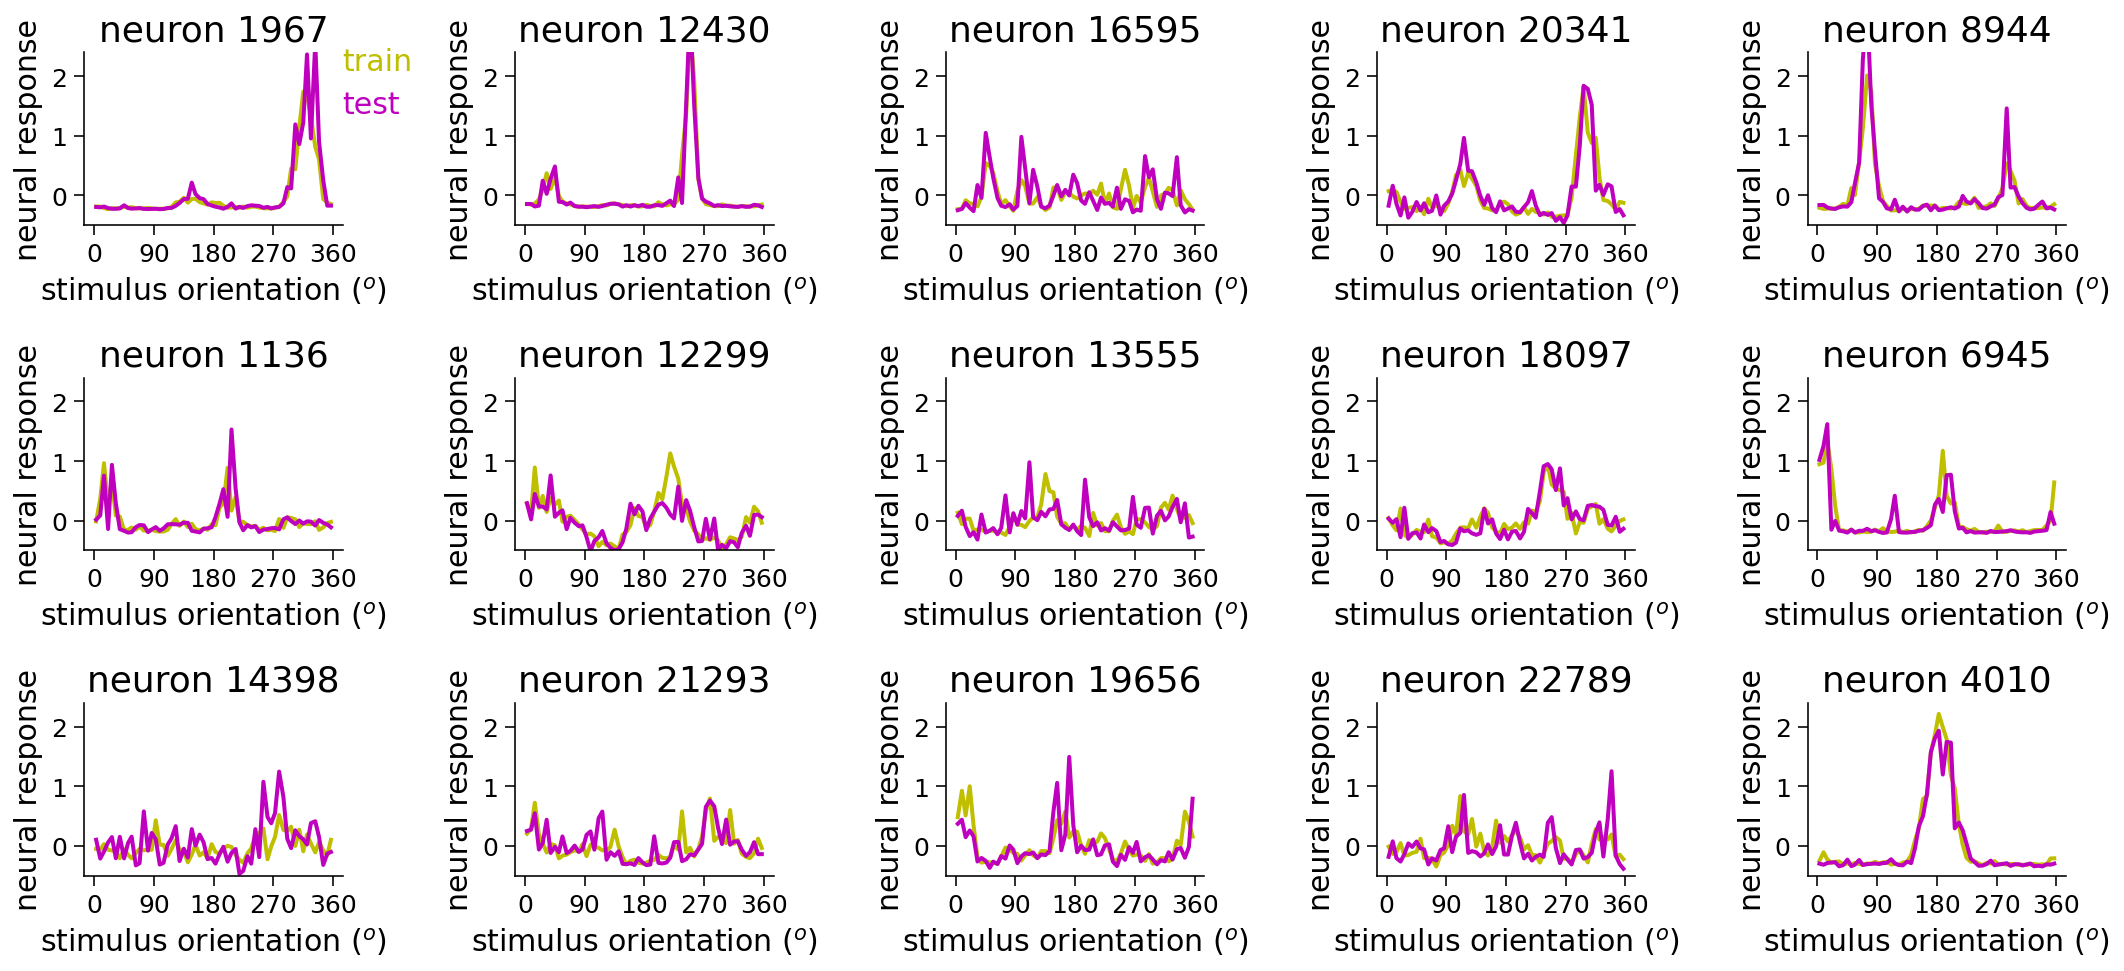

In [ ]:
#@title
#@markdown Execute this cell to load data and plot neural tuning curves

### Load data and bin at 8 degrees
# responses are split into test and train
resp_train, resp_test, stimuli = load_data_split()
n_stimuli, n_neurons = resp_train.shape
print('resp_train contains averaged responses of %i neurons to %i binned stimuli' % (n_neurons, n_stimuli))
#print(resp_train.shape)

# also make stimuli into array of 0's and 1's
n_bins = len(stimuli)
stim_binary = torch.eye(n_bins, dtype=torch.float32)

# Visualize tuning curves
fig, axs = plt.subplots(3, 5, figsize=(15,7))
for k, ax in enumerate(axs.flatten()):
  neuron_index = np.random.choice(n_neurons)  # pick random neuron
  plot_tuning(ax, stimuli, resp_train[:, neuron_index], resp_test[:, neuron_index], neuron_index, linewidth=2)
  if k==0:
    ax.text(1.0, 0.9, 'train', color='y', transform=ax.transAxes)
    ax.text(1.0, 0.65, 'test', color='m', transform=ax.transAxes)
fig.tight_layout()
plt.show()

---
# Section 2: Introduction to convolutions



Video available at https://youtube.com/watch?v=vPNu8CNg9i4


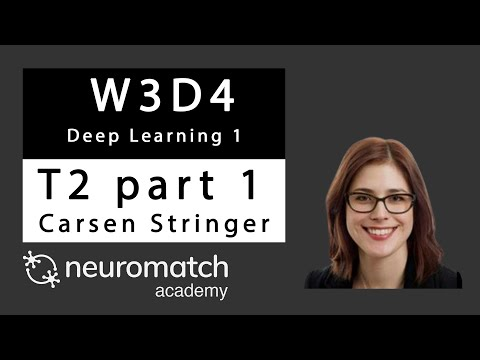

In [ ]:
#@title Video 1: Intro to convolutions
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="vPNu8CNg9i4", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

## Section 2.1: 1d convolution in numpy

We provide an example function below, described in the video, which performs a 1D convolution of a stimulus input $s$ with **filter** $f$ of size $K$ (these filters are also called *kernels*). In particular, it computes:

$$a_x = \sum^{K/2}_{i=-K/2} f_i \, s_{x-i}$$

where $a_x$ is the convolutional output at position $x$.

There is no exercise in this section but make sure you understand what is happening in the function below (i.e. what a convolution is). It can be helpful to write or draw this out on paper to clarify! You could even make your own short stimulus and filter and calculate what you think the convolutional output should be by hand, and then compare to the function output.

In [ ]:
def convolve1d(stimulus, f, pad, stride):
  """ Pads stimulus and performs 1d convolution

  Args:
    stimulus (ndarray): the 1D input for the convolution
    f (ndarray): the 1D filter for the convolution
    pad (scalar): the amount of zero padding for the stimulus
    stride (scalar): how far the filter moves every step

  Returns:
    (ndarray): convolutional output, same size as stimulus
  """

  # Pad the stimulus
  zero_pads = np.zeros(pad)
  padded_stimulus = np.concatenate((zero_pads, stimulus, zero_pads))

  # Initialize convolutional output
  a = np.nan * np.zeros(360)

  # Compute the convolution
  for x in np.arange(0+pad, 360+pad, stride, int): # loop over positions x

    # Compute element-wise multiplication between filter and stimulus
    a[x - pad] = (f * padded_stimulus[x-pad : x+pad]).sum()

  return a

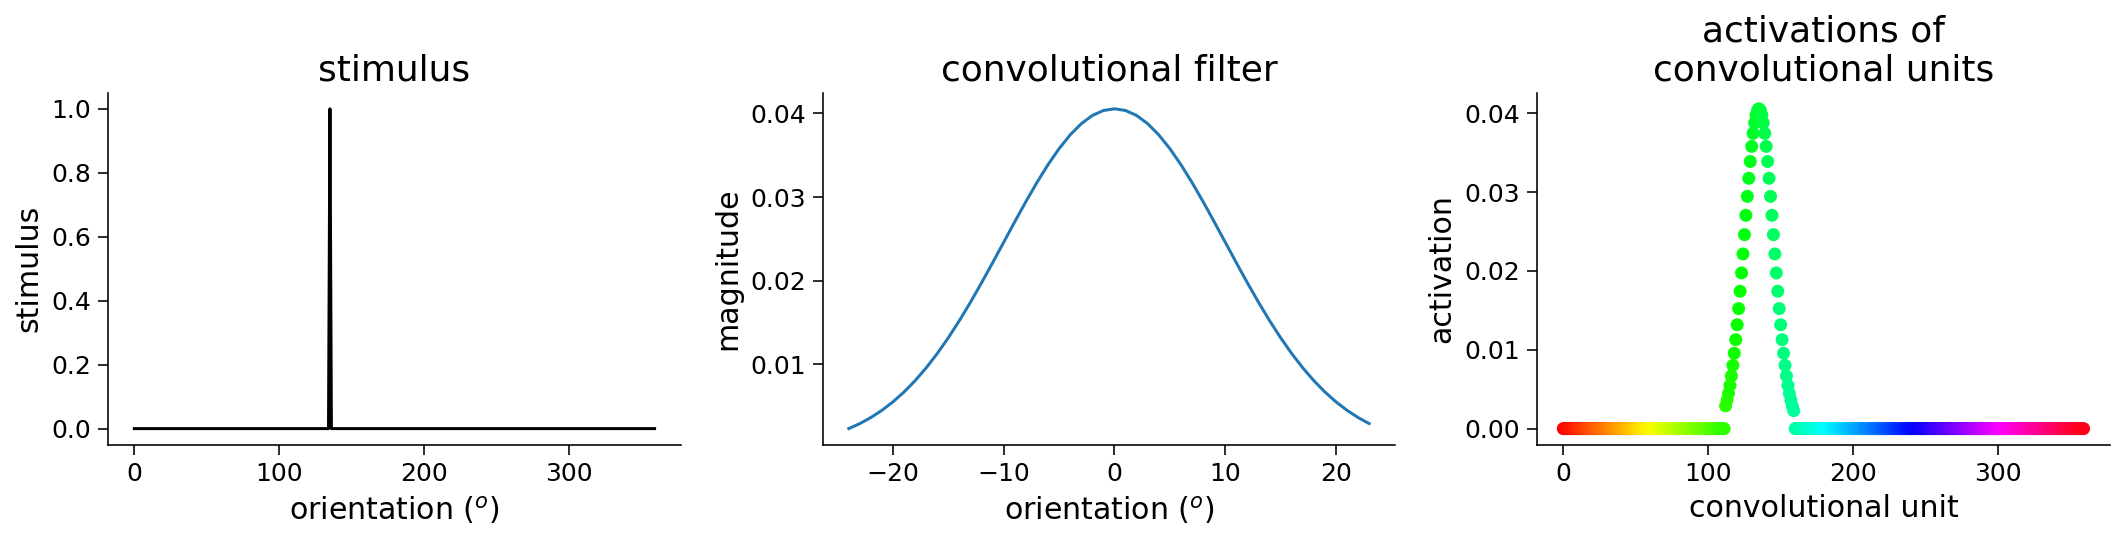

In [ ]:
#@title
#@markdown Execute this cell to call convolve1d with a Gaussian filter and plot results

# Convolutional parameters
K = 49 # size of convolutional filter
stride = 1 # how often to compute the convolution along the stim axis
pad = K // 2 # we will need to pad stimulus with zeros to perform convolution

# Create stimulus
ori = 135
stimulus = np.zeros(360)
stimulus[ori] = 1.0

# Create Gaussian filter
# we will use the code from W2D1 (bayes day) to create this!
# mean of gaussian mu=0
i = np.arange(-pad, pad)
f = my_gaussian(i, 0.0, sigma=10)

# Call function
a = convolve1d(stimulus, f, pad, stride)

# Plot results
fig = plt.figure(figsize=(15,4))
plot_conv(pad, stimulus, f, a)
plt.show()

## Section 2.2: Convolutional layer

You have just learned how to compute what is called a single convolutional **channel**: a single filter applied to the input resulting in several units, where the number of units depends on the *stride* you set.

(Note if filter size *K* is odd and you set the *pad=K//2* and *stride=1* (as is the default above), you get a **channel** of units that is the same size as the input.)

*Contemplation:* How does a neuron potentially combine those activation units and create the tuning curves they have? Will we need more than one convolutional filter to recreate all the responses we see?



[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W3D4_DeepLearning1/solutions/W3D4_Tutorial2_Solution_185efdad.py)



Let's add more convolutional channels and implement this operation efficiently using pytorch. A *layer* of convolutional channels can be implemented with one line of code using the PyTorch class `nn.Conv1d()`, which requires the following arguments for initialization:
  * $C^{in}$: the number of input channels
  * $C^{out}$: the number of output channels (number of different convolutional filters)
  * $K$: the size of the $C^{out}$ different convolutional filters
  
When you run the network, you can input a stimulus of arbitrary length ($H^{in}$), but it needs to be shaped as a 2D input $C^{in} \times H^{in}$. In our case, $C^{in}=1$ because there is only one orientation input and $H^{in}$ is the number of stimulus bins $B$.

<p align="center">
  <img src="https://github.com/NeuromatchAcademy/course-content/blob/master/tutorials/static/convolutional_layer.PNG?raw=true" width="600" />
</p>

In [ ]:
class ConvolutionalLayer(nn.Module):
  """Deep network with one convolutional layer
     Attributes: conv (nn.Conv1d): convolutional layer
  """
  def __init__(self, c_in=1, c_out=8, K=9):
    """Initialize layer

    Args:
        c_in: number of input stimulus channels
        c_out: number of output convolutional channels
        K: size of each convolutional filter

    """
    super().__init__()
    self.conv = nn.Conv1d(c_in, c_out, kernel_size=K,
                          padding=K//2, stride=1)

  def forward(self, s):
    """Run stimulus through convolutional layer

    Args:
        s (torch.Tensor): n_stimuli x h tensor with stimuli

    Returns:
        (torch.Tensor): n_stimuli x c_out x h tensor with convolutional layer unit activations.

    """
    s = s.unsqueeze(1)  # n_stimuli x 1 x h, add a singleton dimension for the single channel
    a = self.conv(s)  # output of convolutional layer

    return a

### Exercise 1: 1D convolution in pytorch 

We will now run the convolutional layer on our stimulus. In particular, we will use the binary stimuli (`stim_binary`), which is a 60 x 60 tensor where each row contains the binary stimuli for one orientation (all zeros except for a one at that orientation). This tensor is size 60 instead of 360 because we have binned the orientations. Each row of this matrix is a different example orientation that we want to convolve - see cell below to visualize three rows of this tensor.



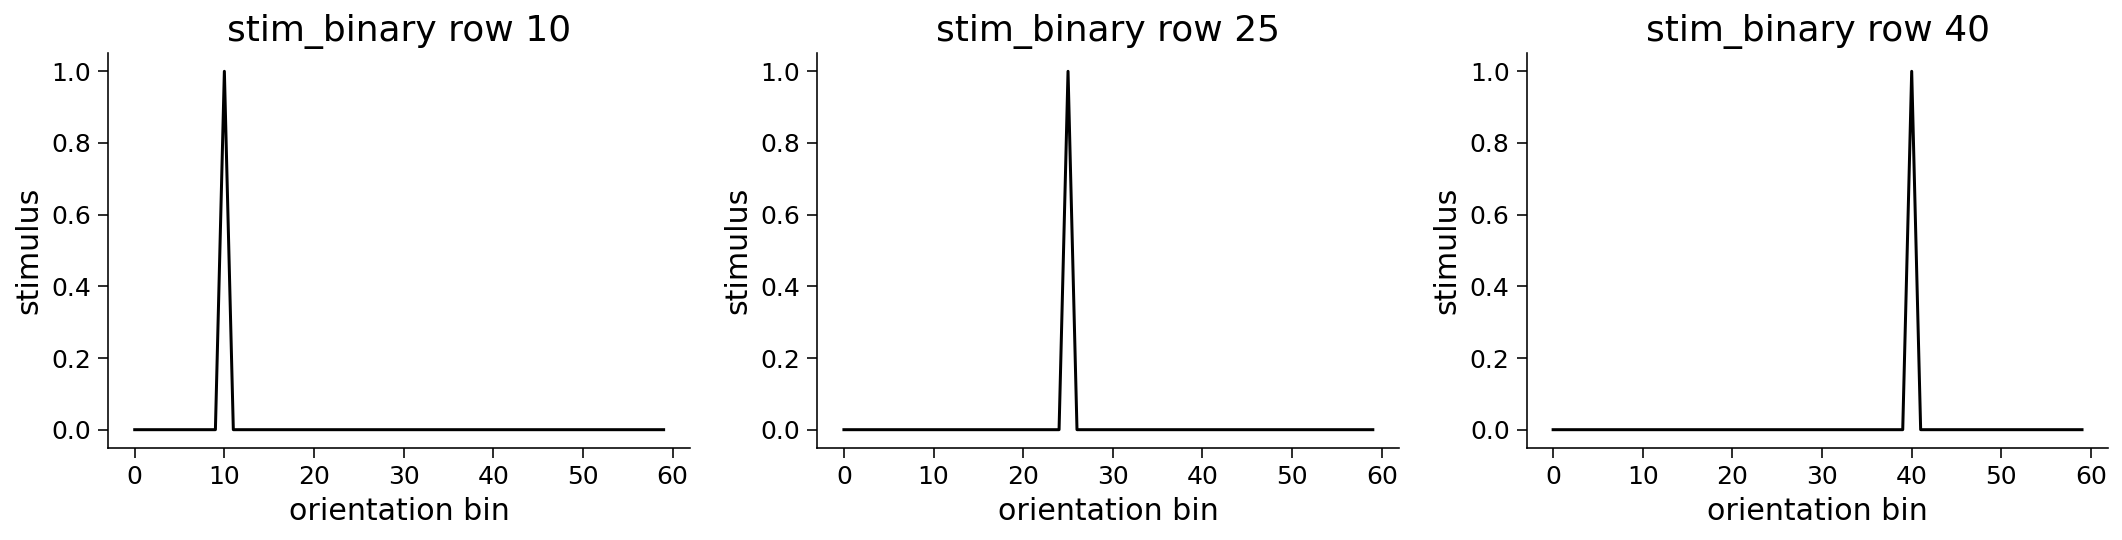

In [ ]:
# @markdown Execute this cell to visualize stim_binary
row_inds = [10, 25, 40]
fig = plt.figure(figsize=(15,4))

for j, row_ind in enumerate(row_inds):
  ax = fig.add_subplot(1, 3, j+1)
  ax.plot(np.arange(0, 60), stim_binary[row_ind,:], 'k')
  ax.set_title('stim_binary row '+str(row_ind))
  ax.set_xlabel('orientation bin')
  ax.set_ylabel('stimulus')

plt.show()

`nn.Conv1d` takes in a tensor of size $(N, C^{in}, H^{in}$) where $N$ is the number of examples, $C^{in}$ is the number of input channels, and $H^{in}$ is the number of stimulus bins $B$. Since our stimulus has only one input channel,  the `ConvolutionalLayer` class adds the $C^{in}$ dimension for us: we need to input an $(N, H^{in})$ stimulus, which `stim_binary` is!  


We will plot the outputs of the convolution. `convout` is a tensor of size $(N, C^{out}, H^{in})$ where $N$ is the number of examples and $C^{out}$ are the number of convolutional channels. In the plot, the activations for a single channel are shown in one color. 

torch.Size([60, 8, 60])


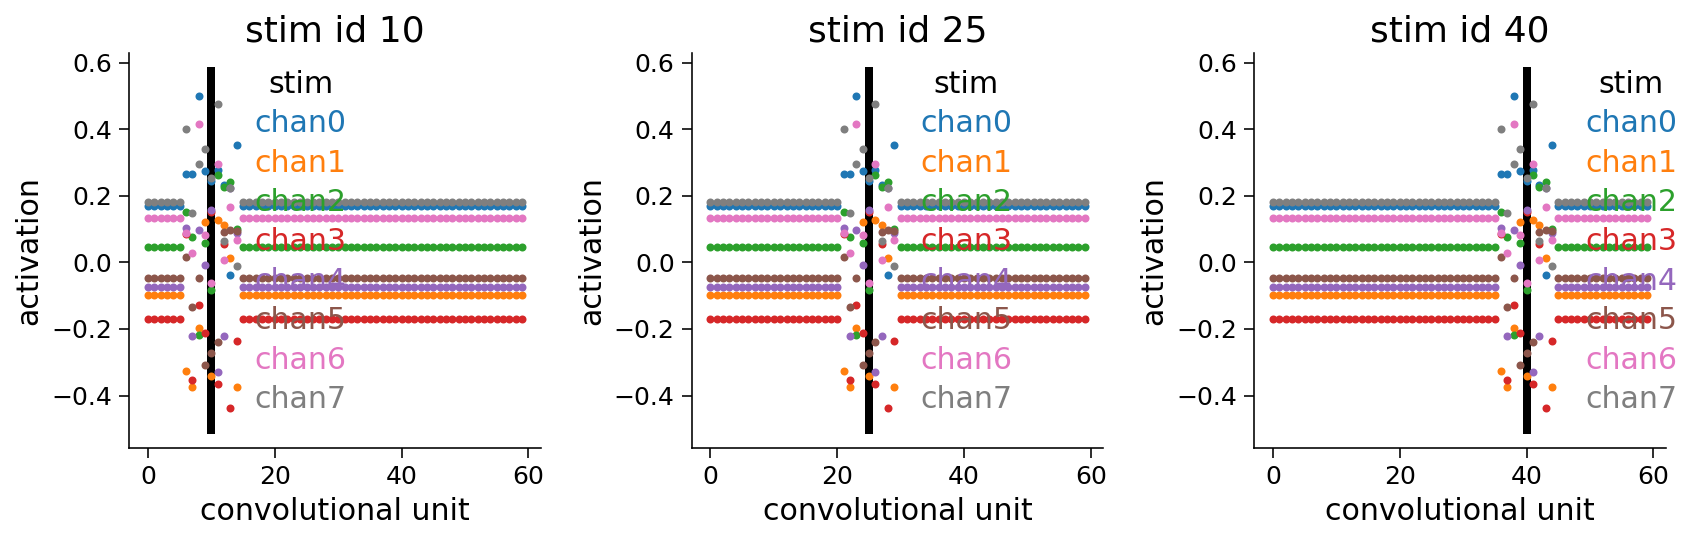

In [ ]:
# Convolution layer parameters
K = 9 # filter size, now that we've binned let's make this smaller than for the numpy conv
conv_channels = 8 # how many convolutional channels to have in our layer

convout = np.zeros(0) # assign convolutional activations to convout

################################################################################
## TODO for students: compute convolution activations from stim_binary using pytorch
# Complete and uncomment
################################################################################

# Initialize conv layer
# convLayer = ConvolutionalLayer(...)

# Call conv layer on stimulus
# convout = convLayer(...)
# convout = convout.detach() # detach gradients
# print(convout.shape) # can you identify what each of these dimensions are?

# Initialize conv layer
convLayer = ConvolutionalLayer(c_in=1, c_out=conv_channels, K=K)

# Call conv layer on stimulus
convout = convLayer(stim_binary)
convout = convout.detach() # detach gradients
print(convout.shape) # can you identify what each of these dimensions are?

# Plot results
plot_example_activations(convout)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W3D4_DeepLearning1/solutions/W3D4_Tutorial2_Solution_44e9267a.py)

*Example output:*

<img alt='Solution hint' align='left' width=844 height=270 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W3D4_DeepLearning1/static/W3D4_Tutorial2_Solution_44e9267a_1.png>



#### Think!
  - Why are the convolutional activations for a given channel the same for many units?
  - What is the width of the non-constant activations (i.e. how many units in a given channel would differ from the constant)?
  - How many weights does this convLayer have? 
  - How many would it have if it were a fully connected layer? 

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W3D4_DeepLearning1/solutions/W3D4_Tutorial2_Solution_32703d8b.py)



---
# Section 3: Encoding model using convolutions

Video available at https://youtube.com/watch?v=Me8X3Kro0EE


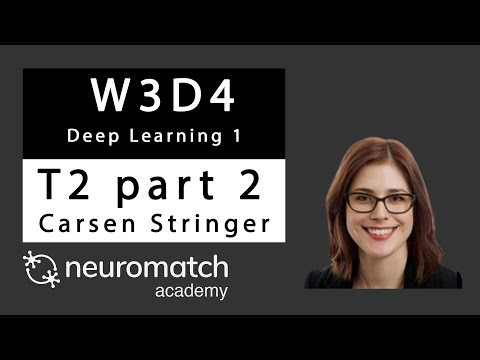

In [ ]:
#@title Video 2: Encoding model using convolutions
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="Me8X3Kro0EE", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

## Section 3.1: Convolutional layer & fully connected layer

We will now build an encoding model by hooking this convolutional layer up to a fully connected layer, like the one that we used in Tutorial 1 (`nn.Linear`). We will use this model to predict neural responses.

<p align="center">
  <img src="https://github.com/NeuromatchAcademy/course-content/blob/master/tutorials/static/conv_fc.PNG?raw=true" width="800" />
</p>

This linear layer will have weights $W^{out}$ and we will get an output vector $\mathbf{y}$ of predicted neural responses.

### Exercise 2: Implement encoding model 

In this exercise, you will create the encoding model described above. In particular, you will:

* Add a fully connected layer to `__init__` method of network.
* Add a fully connected layer to `forward` method of network.

We will then train the network using the helper function `train`. Full training will take a few minutes: if you want to train for just a few steps to speed up the code while iterating on your code, you can decrease the `n_iter` input from 500.

In [ ]:
class ConvFC(nn.Module):
  """Deep network with one convolutional layer + one fully connected layer

  Attributes:
    conv (nn.Conv1d): convolutional layer
    dims (tuple): shape of convolutional layer output
    out_layer (nn.Linear): linear layer

  """

  def __init__(self, n_neurons, c_in=1, c_out=8, K=9, b=60):
    """ initialize layer
    Args:
        c_in: number of input stimulus channels
        c_out: number of convolutional channels
        K: size of each convolutional filter
        h: number of stimulus bins, n_bins
    """
    super().__init__()
    self.conv = nn.Conv1d(c_in, c_out, kernel_size=K, padding=K//2)
    self.dims = (c_out, b)  # dimensions of conv layer output
    M = np.prod(self.dims) # number of hidden units

    ################################################################################
    ## TO DO for students: add fully connected layer to network (self.out_layer)
    # Fill out function and remove
    raise NotImplementedError("Student exercise: add fully connected layer to initialize network")
    ################################################################################
    self.out_layer = nn.Linear(M, ...)

    nn.init.normal_(self.out_layer.weight, std=0.01) # initialize weights to be small

  def forward(self, s):
    """ Predict neural responses to stimuli s

    Args:
        s (torch.Tensor): p x L tensor with stimuli

    Returns:
        torch.Tensor: p x N tensor with convolutional layer unit activations.

    """
    s = s.unsqueeze(1)  # p x 1 x L, add a singleton dimension for the single channel
    a = self.conv(s)  # output of convolutional layer
    a = a.view(-1, np.prod(self.dims))  # flatten each convolutional layer output into a vector

    ################################################################################
    ## TO DO for students: add fully connected layer to forward pass of network (self.out_layer)
    # Fill out function and remove
    raise NotImplementedError("Student exercise: add fully connected layer to network")
    ################################################################################
    y = ...

    return y


# Choose loss function
MSE_loss = nn.MSELoss()

## Initialize network
# net = ConvFC(n_neurons)

## Run GD on training set data
## ** this time we are also providing the test data to estimate the test loss
# train_loss, test_loss = train(net, MSE_loss, stim_binary, resp_train,
#                               test_data=stim_binary, test_labels=resp_test,
#                               n_iter=500, learning_rate=20)

## Plot the training loss over iterations of GD
# plot_training_curves(train_loss, test_loss)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W3D4_DeepLearning1/solutions/W3D4_Tutorial2_Solution_fda4c007.py)

*Example output:*

<img alt='Solution hint' align='left' width=558 height=414 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W3D4_DeepLearning1/static/W3D4_Tutorial2_Solution_fda4c007_11.png>



We trained this network to predict the neural responses -- see the yellow curve for the training loss. We also computed the test loss every 50 iterations. The training loss goes down throughout training but the testing loss doesn’t -- why is this? *We are overfitting to the NOISE in the training set.*

Let’s look at a prediction for a single neuron (below). The yellow curve is the training data, the pink curve is the testing data and the prediction is in green. You can barely see the yellow curve because the prediction has fit so well to the training data. However, some of what it has fit is noise. 

If we look at the weight matrix, we see that the weights are all positive or negative. Did we expect this to happen? Or did we think that this tuning curve is the sum of only a few filters and positions?



[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W3D4_DeepLearning1/solutions/W3D4_Tutorial2_Solution_5d5c2c4f.py)



output shape:  torch.Size([60, 23589])
output weights shape:  torch.Size([23589, 480])


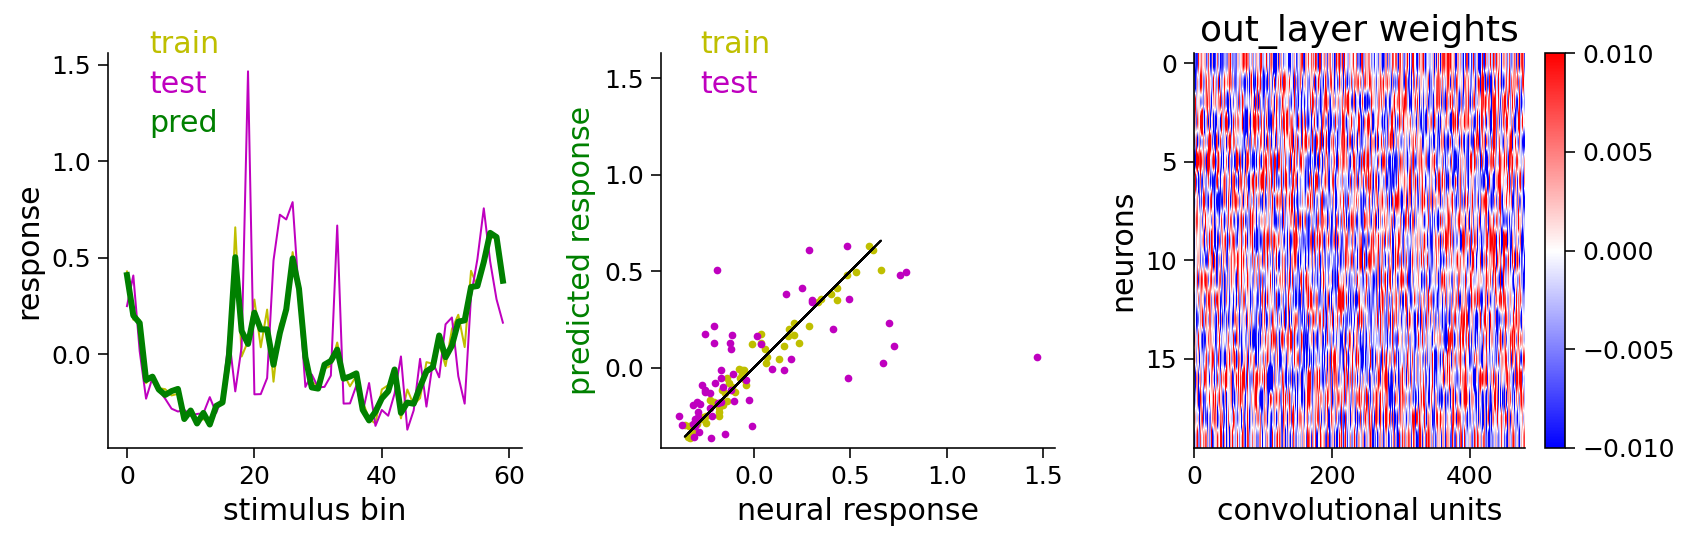

In [ ]:
#@title
#@markdown Execute this cell to examine prediction for example neuron and see weights

# Input stimuli to network
y_pred = net(stim_binary)
print('output shape: ', y_pred.shape) # what are the two dimensions of this network output?

# Plot example neural response prediction and some fully-connected layer weights

# Look at the weights of the out_layer of the network
weights = net.out_layer.weight.detach()
print('output weights shape: ', weights.shape) # what are these two dimensions of the fully connected layer weights?

# Plot prediction + neuron + weights
neuron_index = np.random.choice(n_neurons)
plot_pred_weights(y_pred[:,neuron_index].detach(), resp_train[:,neuron_index],
                  resp_test[:,neuron_index], weights[:20])

*Comprehension check*: what does each dimension of the output and output weights correspond to?


[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W3D4_DeepLearning1/solutions/W3D4_Tutorial2_Solution_fa083d69.py)



We can reduce overfitting using L2 regularization as we learned on W1D4. 

Additionally there is another type of regularization you might want... If we think of a neuron as a sum of a few convolutional filters, we might expect the weight matrix of the fully-connected layer to be sparse. Therefore, we can also apply an L1 regularization penalty to enforce sparsity. 



---
# (Bonus) Section 4: Regularization


Video available at https://youtube.com/watch?v=Qnn5OPHKo5w


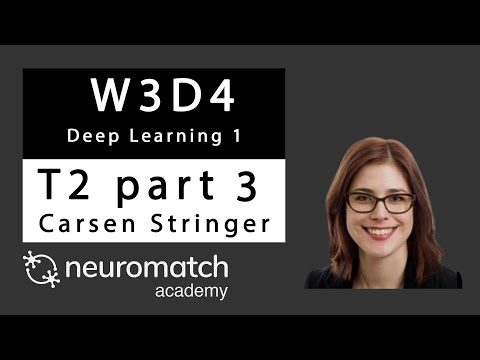

In [ ]:
#@title Video 3: Regularization
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="Qnn5OPHKo5w", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video


As discussed in the lecture, it is often important to incorporate regularization terms into the loss function to avoid overfitting. In particular, in this case, we want to use these terms to enforce sparsity in the output layer. 

Here we'll consider the classic L2 regularization penalty $\mathcal{R}_{L2}$, which is the sum of squares of each weight in the network $\sum_{ij} {\mathbf{W}^{out}_{ij}}^2$ times a constant that we call `L2_penalty`.

We will also add an L1 regularization penalty $\mathcal{R}_{L1}$ to enforce sparsity of the weights, which is the sum of the absolute values of the weights $\sum_{ij} |{\mathbf{W}^{out}_{ij}}|$ times a constant that we call `L1_penalty`.

We will add both of these to the loss function:
\begin{equation}
    L = (y - \tilde{y})^2 + \mathcal{R}_{L2} + \mathcal{R}_{L1}
\end{equation}

The parameters `L2_penalty` and `L1_penalty` are inputs to the train function.

### (Bonus) Exercise 3: Add regularization to training 

We will create a new loss function that adds L1 and L2 regularization. 
In particular, you will:
* add L2 loss penalty to the weights 
* add L1 loss penalty to the weights


We will then train the network using this loss function. Full training will take a few minutes: if you want to train for just a few steps to speed up the code while iterating on your code, you can decrease the n_iter input from 500. 

Hint: since we are using `torch` instead of `np`, we will use `torch.abs` instead of `np.absolute`. You can use `torch.sum` or `.sum()` to sum over a tensor.





In [ ]:
def regularized_MSE_loss(output, target, weights=None, L2_penalty=0, L1_penalty=0):
  """loss function for MSE

  Args:
    output (torch.Tensor): output of network
    target (torch.Tensor): neural response network is trying to predict
    weights (torch.Tensor): fully-connected layer weights (net.out_layer.weight)
    L2_penalty : scaling factor of sum of squared weights
    L1_penalty : scalaing factor for sum of absolute weights

  Returns:
    (torch.Tensor) mean-squared error with L1 and L2 penalties added

  """

  loss_fn = nn.MSELoss()
  loss = loss_fn(output, target)

  ##############################################################################
  # TO DO: add L1 and L2 regularization to the loss function and remove the error
  raise NotImplementedError("Student exercise: complete regularized_MSE_loss")
  ##############################################################################

  if weights is not None:
    L2 = L2_penalty * ...
    L1 = L1_penalty * ...
    loss += L1 + L2

  return loss

# Initialize network
net = ConvFC(n_neurons)

# Uncomment below to test your function

# Train network
# train_loss, test_loss = train(net, regularized_MSE_loss, stim_binary, resp_train,
#                               test_data=stim_binary, test_labels=resp_test,
#                               learning_rate=10, n_iter=500,
#                               L2_penalty=1e-4, L1_penalty=1e-6)

# Plot the training loss over iterations of GD
# plot_training_curves(train_loss, test_loss)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W3D4_DeepLearning1/solutions/W3D4_Tutorial2_Solution_c4027856.py)

*Example output:*

<img alt='Solution hint' align='left' width=558 height=413 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W3D4_DeepLearning1/static/W3D4_Tutorial2_Solution_c4027856_11.png>



If we now train the network with these regularization penalties we find that the train and test loss are similar throughout training: both continue decreasing.

We will now look at the predictions after using the regularized loss function. We can see below that the prediction is much smoother than before! This is because the weight matrix is in fact sparser (zero is represented by white in this color map)


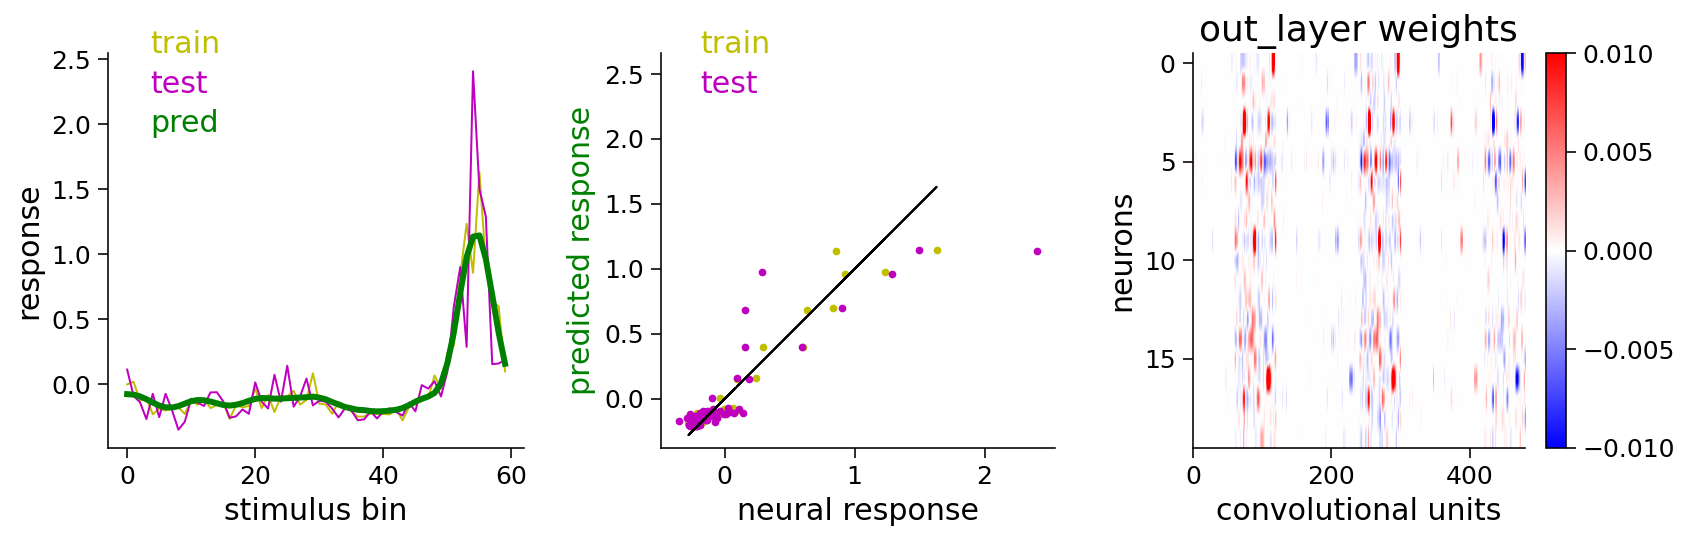

In [ ]:
#@title
#@markdown Execute this cell to examine prediction for example neuron and see weights

# Plot prediction + neuron + weights
weights = net.out_layer.weight.detach()
y_pred = net(stim_binary)
neuron_index = np.random.choice(n_neurons)
plot_pred_weights(y_pred[:,neuron_index].detach(), resp_train[:,neuron_index],
                  resp_test[:,neuron_index], weights[:20])


Now let's look at what the predictions look like for many neurons

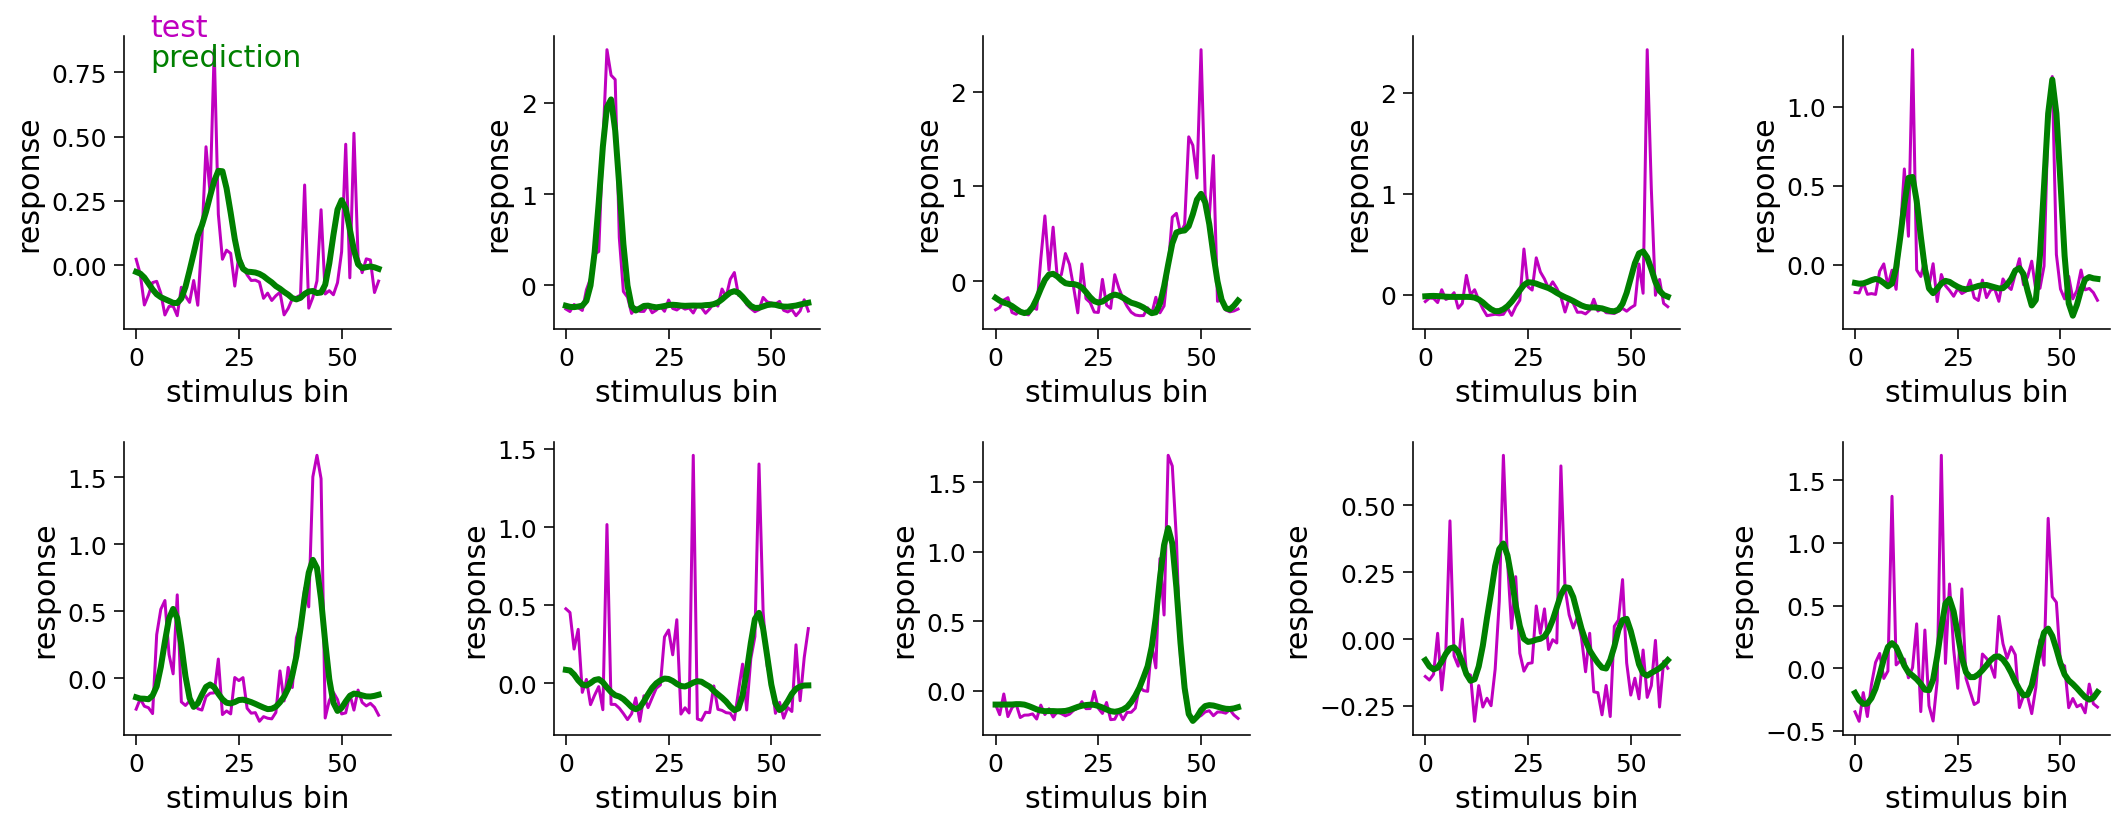

In [ ]:
#@title
#@markdown Execute this cell to examine predictions for random subsets of neurons

# Visualize tuning curves & plot neural predictions
fig, axs = plt.subplots(2, 5, figsize=(15,6))
for k, ax in enumerate(axs.flatten()):
  ineur = np.random.choice(n_neurons)
  plot_prediction(ax, y_pred[:,ineur].detach(), resp_test[:,ineur])
  if k==0:
    ax.text(.1, 1., 'test', color='m', transform=ax.transAxes)
    ax.text(.1, .9, 'prediction', color='g', transform=ax.transAxes)

fig.tight_layout()
plt.show()

---
# Summary

In this notebook, we built and evaluated a neural network based encoding model to predict neural responses from stimuli. To do so we :
* implemented a basic convolution filter
* implemented and trained a convolutional neural network with multiple filters to predict neural responses using PyTorch
* learned about and implemented L2/L1 regularization to avoid overfitting

What can this tell us about the representation of oriented gratings in mouse visual cortex? Maybe we can think of interpreting each of the convolutional channels as a computation performed by a single group of neurons in thalamus, and each visual cortical neuron combines various groups of thalamic neurons. But we'd have to test hypotheses like these by, for instance, recording thalamic neurons.


Tutorial 3 is bonus, although we recommend watching the videos if possible!

---
# Appendix

Video available at https://youtube.com/watch?v=eU74NFroIHk


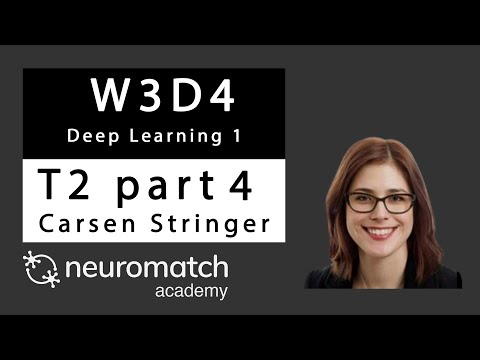

In [ ]:
#@title Video 4: Some practical advice for fitting neural networks
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="eU74NFroIHk", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

## Why CNN's?

CNN models are particularly [well-suited](https://www.nature.com/articles/nn.4244) to modeling the visual system for a number of reasons:

1. **Distributed computation**: like any other neural network, CNN's use distributed representations to compute -- much like the brain seems to do. Such models, therefore, provide us with a vocabulary with which to talk and think about such distributed representations. Because we know the exact function the model is built to perform (e.g. orientation discrimination), we can analyze its internal representations with respect to this function and begin to interpret why the representations look the way they do. Most importantly, we can then use these insights to analyze the structure of neural representations observed in recorded population activity. We can qualitatively and quantitatively compare the representations we see in the model and in a given population of real neurons to hopefully tease out the computations it performs.

2. **Hierarchical architecture**: like in any other deep learning architecture, each layer of a deep CNN comprises a non-linear transformation of the previous layer. Thus, there is a natural hierarchy whereby layers closer to the network output represent increasingly more abstract information about the input image. For example, in a network trained to do object recognition, the early layers might represent information about edges in the image, whereas later layers closer to the output might represent various object categories. This resembles the [hierarchical structure of the visual system](https://pubmed.ncbi.nlm.nih.gov/1822724/), where [lower-level areas](https://www.jneurosci.org/content/25/46/10577.short) (e.g. retina, V1) represent visual features of the sensory input and [higher-level areas](https://www.sciencedirect.com/science/article/pii/S089662731200092X) (e.g. V4, IT) represent properties of objects in the visual scene. We can then naturally use a single CNN to model multiple visual areas, using early CNN layers to model lower-level visual areas and late CNN layers to model higher-level visual areas.
  
  Relative to fully connected networks, CNN's, in fact, have further hierarchical structure built-in through the max pooling layers. Recall that each output of a convolution + pooling block is the result of processing a local patch of the inputs to that block. If we stack such blocks in a sequence, then the outputs of each block will be sensitive to increasingly larger regions of the initial raw input to the network: an output from the first block is sensitive to a single patch of these inputs, corresponding to its "receptive field"; an output from the second block is sensitive to a patch of outputs from the first block, which together are sensitive to a larger patch of raw inputs comprising the union of their receptive fields. Receptive fields thus get larger for deeper layers (see [here](http://colah.github.io/posts/2014-07-Conv-Nets-Modular/) for a nice visual depiction of this). This resembles primate visual systems, where neurons in higher-level visual areas respond to stimuli in wider regions of the visual field than neurons in lower-level visual areas.

3. **Convolutional layers**: through the weight sharing constraint, the outputs of each channel of a convolutional layer process different parts of the input image in exactly the same way. This architectural constraint effectively builds into the network the assumption that objects in the world typically look the same regardless of where they are in space. This is useful for modeling the visual system for two (largely separate) reasons:
  * Firstly, this assumption is generally valid in mammalian visual systems, since mammals tend to view the same object from many perspectives. Two neurons at a similar hierarchy in the visual system with different receptive fields could thus end up receiving statistically similar synaptic inputs, so that the synaptic weights developed over time may end up being similar as well.
  * Secondly, this architecture significantly improves object recognition ability. Object recognition was essentially an unsolved problem in machine learning until the [advent](https://en.wikipedia.org/wiki/AlexNet) of techniques for effectively training *deep* convolutional neural networks. Fully connected networks on their own can't achieve object recognition abilities anywhere close to human levels, making them bad models of human object recognition. Indeed, it is generally the case that [the better a neural network model is at object recognition, the closer the match between its representations and those observed in the brain](https://www.pnas.org/content/111/23/8619.short). That said, it is worth noting that our much simpler orientation discrimination task (in Tutorial 3) can be solved by relatively simple networks.